# Lab 4: Text Processing
*Due: Friday April 1st*


In this lab, you will use some of the text similarity concepts presented in lecture for two simple applications: sentence completion, and a basic question-and-answer service.

## Part 1: Text similarity fundamentals (20 pts)

In this part of the lab, we will walk you through some of the text similarity approaches presented in lecture once again, as a basis for the later parts. The overall goal of this part is to determine the similarity bewtween pairs of sentences drawn from `korn_sen` below.

### 1.1 Setup
First, run the cells below to import necessary packages and define helper functions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm as cm
from sklearn.metrics.pairwise import cosine_similarity
import sklearn.feature_extraction
import nltk.stem.porter 
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import re, json, requests

np.set_printoptions(precision=2)

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
korn_sen = [
    "Tim loves the band Korn.",
    "Tim adores the rock group Korn.",
    "Tim loves eating corn.",
    "Tim used to love Korn, but now he hates them.",
    "Tim absolutely loves Korn.",
    "Tim completely detests the performers named Korn",
    "Tim has a deep passion for the outfit the goes by the name of Korn",
    "Tim loves listening to the band Korn while eating corn."
]

In [3]:
def plot_sim_matrix(m,sens):
    cmap = cm.get_cmap('RdYlGn')
    fig, ax = plt.subplots(figsize=(8,8))
    cax = ax.matshow(m, interpolation='nearest', cmap=cmap)
    ax.grid(True)
    plt.title('San Francisco Similarity matrix')
    plt.xticks(range(len(sens)), sens, rotation=90);
    plt.yticks(range(len(sens)), sens);
    fig.colorbar(cax, ticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, .75,.8,.85,.90,.95,1])
    plt.show()

stemmer = nltk.stem.porter.PorterStemmer()
def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

analyzer = sklearn.feature_extraction.text.CountVectorizer(stop_words='english').build_analyzer()

### 1.2 Jaccard vs Cosine similarity (10 pts)
A simple appoach to tokenization would follow the bag-of-words model, vectorizing each sentence based on token counts. Run the code below to perform this task. Then, compute the matrix of Jaccard and cosine similarities among the sentences

In [4]:
def jaccard(s1, s2):
    j = float(len(s1.intersection(s2))) / float(len(s1.union(s2)))
    return j

def bag_jaccard(sen):
    out = np.zeros((len(sen),len(sen)))
    for i in range(len(sen)):
        s = re.sub(r'[^\w\s]', '', sen[i])
        sen1 = set(s.split(" "))
        for j in range(len(sen)):
            s = re.sub(r'[^\w\s]', '', sen[j])
            sen2 = set(s.split(" "))

            out[i][j] = jaccard(sen1, sen2)

    plot_sim_matrix(out, sen)

In [5]:
def bag_cosine(sen):

    f = sklearn.feature_extraction.text.CountVectorizer(analyzer=stemmed_words)
    
    #Count vectorizer translates each document into a vector of counts
    X = f.fit_transform(sen)

    print(f.get_feature_names_out())

    #cosine_similarity computes the cosine similarity between
    #a set of vectors
    cos_sim = cosine_similarity(X)

    plot_sim_matrix(cos_sim, sen)

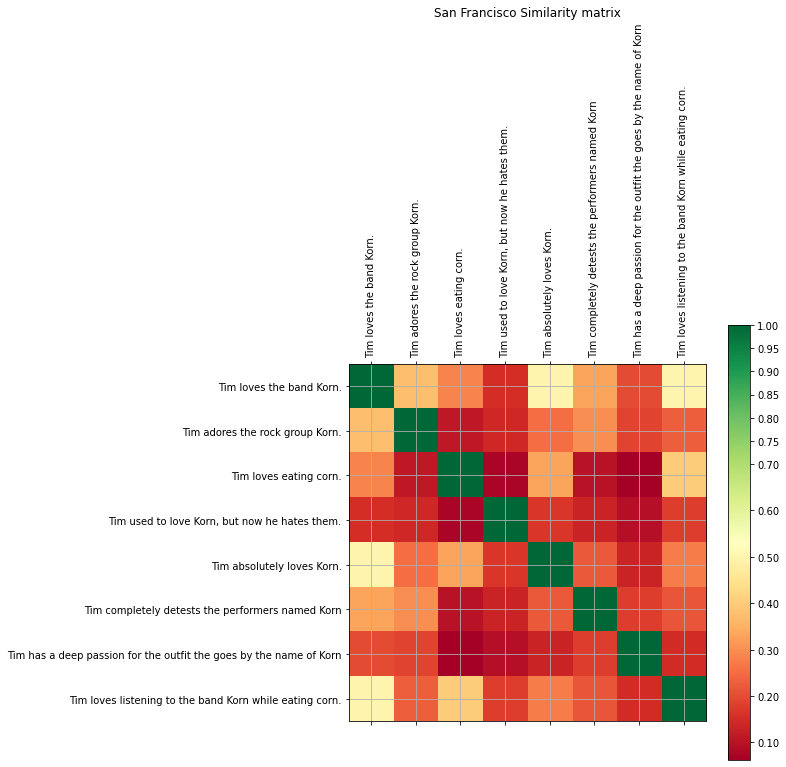

In [6]:
bag_jaccard(korn_sen)

['absolut' 'ador' 'band' 'complet' 'corn' 'deep' 'detest' 'eat' 'goe'
 'group' 'hate' 'korn' 'listen' 'love' 'name' 'outfit' 'passion' 'perform'
 'rock' 'tim' 'use']


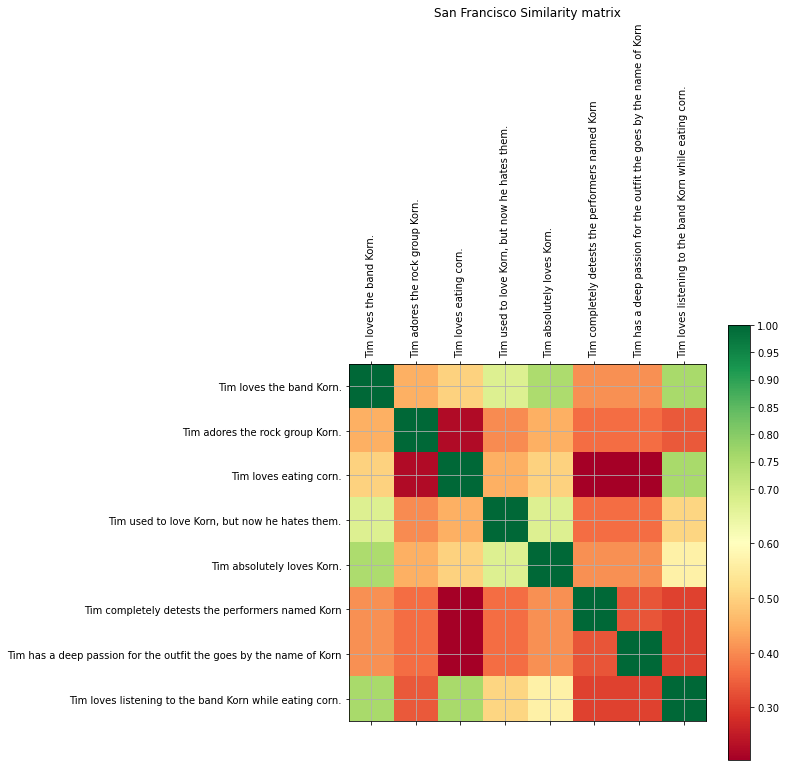

In [7]:
bag_cosine(korn_sen)

**Question (10 pts)**: Contrast the two similarity matrices above, explaining the technical source of the discrepancies. You don't need to explain every pair of sentences for which they differ; provide examples and the general principle. What types of input would each similarity metric be best suited for?

### 1.3 TF/IDF (5 pts)

A more elaborate approach, in contrast to bag-of-words, is TF/IDF. Below are two ways to implement it in Python.

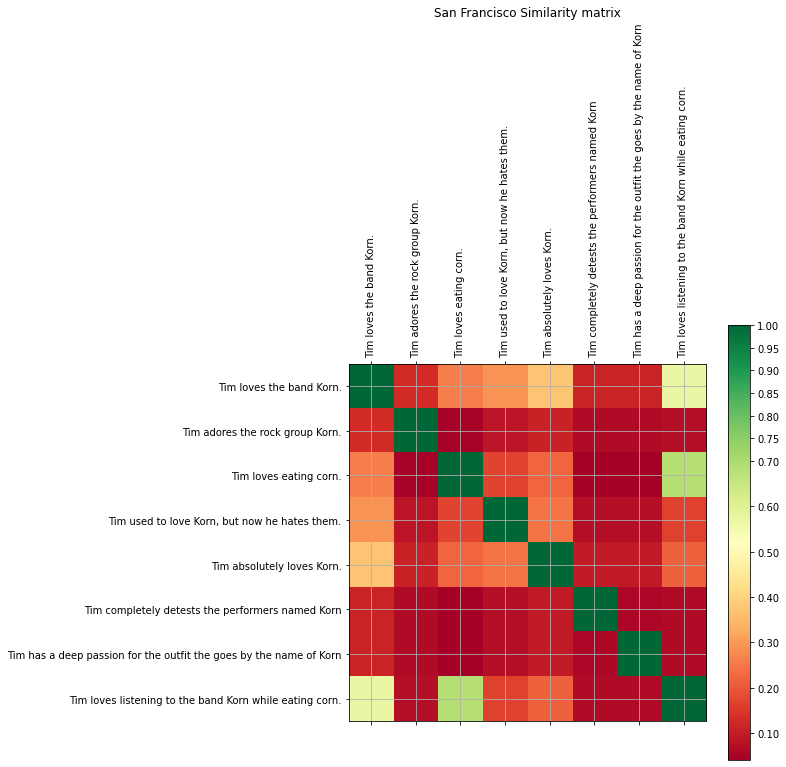

In [8]:
def do_tf_idf_full(sen):
    #from scratch
    f = sklearn.feature_extraction.text.CountVectorizer(analyzer=stemmed_words)
    X = f.fit_transform(sen)
    cnts_ar = np.array(X.toarray()).sum(axis=0)

    doc_len_ar = np.array(X.toarray()).sum(axis=1)
    #should count number of documents where term appears, not just sum, 
    # but ok because our corpus doesn't repeat words
    idf_ar = np.log((1.0/cnts_ar) * len(sen)) + 1
    tdf_out = (np.array(X.toarray()).T/(doc_len_ar)).T * idf_ar
    cos_sim = cosine_similarity(tdf_out)

def do_tf_idf_sklearn(sen):
    #using sklearn
    f  = sklearn.feature_extraction.text.TfidfVectorizer(analyzer=stemmed_words,smooth_idf=False,norm='l1')
    X = f.fit_transform(sen)
    cos_sim = cosine_similarity(X)
    plot_sim_matrix(cos_sim, sen)

do_tf_idf_sklearn(korn_sen)

**Question (5 pts)**: Describe the quality of the output and compare it to part 1.2. Which of the drawbacks of bag-of-words can TF/IDF help mitigate, if any? 

### 1.4 BERT (5 pts)

Finally, we can use a more sophisticated model like BERT to produce the similarity matrix among the given sentences.

Downloading: 100%|██████████| 1.18k/1.18k [00:00<00:00, 770kB/s]
Downloading: 100%|██████████| 10.1k/10.1k [00:00<00:00, 5.55MB/s]
Downloading: 100%|██████████| 116/116 [00:00<00:00, 50.8kB/s]
Downloading: 100%|██████████| 39.3k/39.3k [00:00<00:00, 1.71MB/s]
Downloading: 100%|██████████| 349/349 [00:00<00:00, 96.9kB/s]
Downloading: 100%|██████████| 438M/438M [00:48<00:00, 9.07MB/s] 
Downloading: 100%|██████████| 53.0/53.0 [00:00<00:00, 13.4kB/s]
Downloading: 100%|██████████| 239/239 [00:00<00:00, 153kB/s]
Downloading: 100%|██████████| 466k/466k [00:00<00:00, 7.53MB/s]
Downloading: 100%|██████████| 363/363 [00:00<00:00, 34.0kB/s]
Downloading: 100%|██████████| 13.1k/13.1k [00:00<00:00, 2.98MB/s]
Downloading: 100%|██████████| 232k/232k [00:00<00:00, 5.23MB/s]
Downloading: 100%|██████████| 190/190 [00:00<00:00, 50.1kB/s]


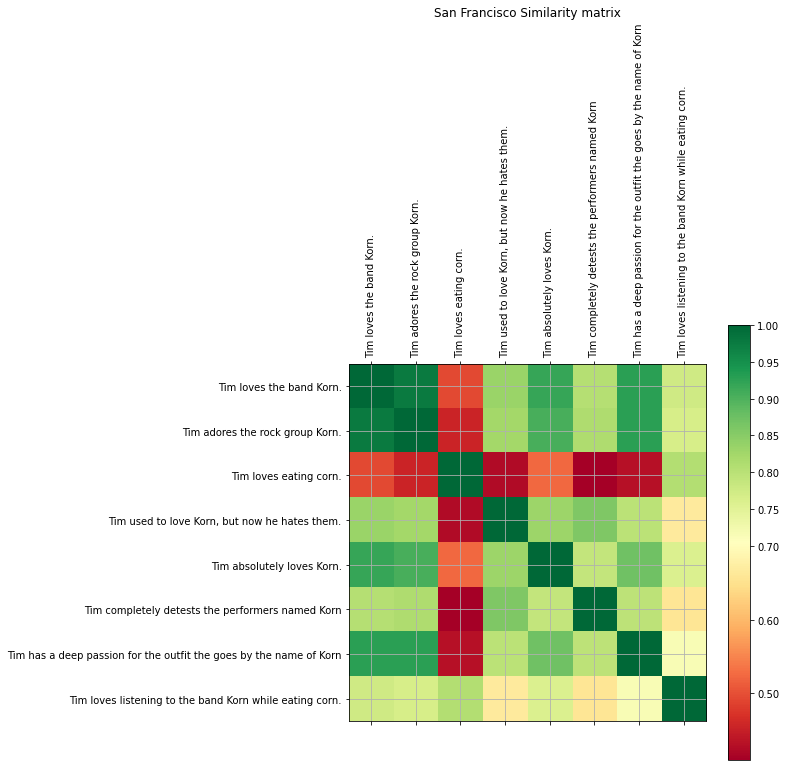

In [9]:
def do_bert(sen):

    model = SentenceTransformer('all-mpnet-base-v2')
    sen_embeddings = model.encode(sen)

    #let's calculate cosine similarity for sentence 0:
    cos_sim = cosine_similarity(sen_embeddings)

    plot_sim_matrix(cos_sim, sen)

do_bert(korn_sen)

**Question (5 pts)**: Describe the quality of the output and compare it to the previous 2 parts. Are there any sentences that remain difficult for BERT?

## Part 2: Sentence completion (35 pts)

In this part of the lab, you will use text similarity in the context of a sentence completion task. Given a dataset of sentences, and the beginning of a sentence, your goal will be to determine the most similar sentence in the dataset.

### 2.1 The Dataset

For this part, we will use a crowdsourced dataset including the first sentence of different novels, available [here](https://github.com/janelleshane/novel-first-lines-dataset).

Run the cell below to download the dataset.

In [10]:
url = "https://raw.githubusercontent.com/janelleshane/novel-first-lines-dataset/master/crowdsourced_all.txt"
resp = requests.get(url)

sentences = resp.text.split("\n")
sentences[0]

'Enter the first sentence of a novel.'

### 2.2 Pre-processing (10 pts)

**Task (5 pts)**: To determine sentence similarity, we would like to pre-process the sentences. However, we still want to retain a copy of the original sentences around, for our final reply to the user. Create a copy of `sentences` in `match`, retaining the sort order of the sentences. Then, remove any duplicate sentences from both `sentences` and `match`, and stem the words in `match`.

In [11]:
match = ...

# Your de-duplication code here

# Your stemming code here

**Task (5 pts)**: Remove stopwords and punctuation from `match` . Provide some indicative metrics related to this pre-processing step (e.g. the most frequent X words before and after stopword removal, or the proportion of words that were stopwords).

In [12]:
# Your punctuation and stopword removal code here

### 2.3 Completing the sentences (15 pts)

**Task (3 pts)**: Fill in the function below, to apply the same preproecssing to incoming sentences, as you applied to the sentences in `match`.

In [13]:
def preprocess_sentence(s):
    processed_s = s
    
    # Your code here
    
    return processed_s

**Task (12 pts)**: Fill in the function below, to retrieve the sentence most similar to `s`. Your implementation should allow toggling between cosine and Jaccard similarity in the bag-of-words model, as well as switching to TF/IDF or BERT, using the value of `option` (one of the strings in `options`). You are free to define additional variables outside `complete`, if needed.

In [14]:
options = ["BAG_COSINE", "BAG_JACCARD", "TF/IDF", "BERT"]

# Your variables here

def complete(s, option):
    
    # Your code here
    
    return sentence

### 2.4 Evaluating alternatives (10 pts)

We now provide a set of unfinished sentences. Run the cell below to import them.

In [7]:
with open("data/example_sentences.txt") as f:
    d = f.read().splitlines()

**Task (10 pts)**: Evaluate your code on `sentence_starts`, using each of the 4 `options`. For some example sentences, print the unfinished fragment you were given and the sentence as completed by the system. Report and discuss your results.

In [ ]:
# Your code here

## Part 3: Question and Answer (45 pts)

In this part of the lab, you will use text similarity in the context of a question-and-answer task. Given a dataset of question-answer pairs, and a novel question, your goal will be to determine the most similar question in the dataset, and provide the user with the corresponding answer.

### 3.1: The Dataset

For this part, we will use the [WebQuestions](http://nlp.stanford.edu/software/sempre/) dataset, used for benchmarking QA engines, especially ones that work on structured knowledge bases.

Run the cell below to download the 4 splits comprising the dataset and store them in variables of the form `data_[SPLIT_NAME]`. You can read more about the inteded purpose of each split [here](https://github.com/brmson/dataset-factoid-webquestions#splits).

In [17]:
files = ["devtest", "val", "trainmodel", "test"]

for f in files:
    url = f"https://raw.githubusercontent.com/brmson/dataset-factoid-webquestions/master/main/{f}.json"
    resp = requests.get(url)
    name = f"data_{f}"
    globals()[name] = json.loads(resp.text)

Now, run the cell below to examine an example entry. Each entry contains a unique `qId` and a list of one or more `answers` to a question, labelled `qText`.

In [18]:
data_devtest[0]

{'qId': 'wqr000000',
 'answers': ['Jazmyn Bieber', 'Jaxon Bieber'],
 'qText': 'what is the name of justin bieber brother?'}

### 3.2 Pre-processing (15 pts)

**Task (5 pts)**: The current partitioning of the data makes sense in the context of training an NLP model, but is inconvenient for our approach. Re-partition the data so that all the questions are accumulated separately from all the answers. Then fill in the function `answers_to_existing()`, which should provide a mapping from an element of `questions` to the correct elements of `answers`.

In [85]:
questions = ...
answers = ...

def answers_to_existing(#Your parameters here 
):
    # Your code here
    
    return ans

**Task (5 pts)**: Apply stemming to the questions. Provide some indicative metrics as to the impact of this pre-processing step (e.g. the number of distinct words before and after stemming). Should we also stem the answers? Why or why not?

In [86]:
# Your stemming code & answers here

**Task (5 pts)**: Remove stopwords from the questions. Again, provide some indicative metrics related to this step (e.g. the most frequent X words before and after stopword removal, or the proportion of words that were stopwords).

In [87]:
# Your stopword removal code here

### 3.3 Finding the most similar question (20 pts)

**Task (3 pts)**: Fill in the function below, to apply the same preproecssing to incoming questions, as you applied to existing ones.

In [3]:
def preprocess_question(q):
    processed_q = q
    
    # Your code here
    
    return processed_q

**Task (17 pts)**: Fill in the function below, to retrieve the answers to the question most similar to `q`. Your implementation should allow toggling between cosine and Jaccard similarity in the bag-of-words model, as well as switching to TF/IDF or BERT, using the value of `option` (one of the strings in `options`). You are free to define additional variables outside `answers_to`, if needed.

In [91]:
options = ["BAG_COSINE", "BAG_JACCARD", "TF/IDF", "BERT"]

# Your variables here

def answers_to(q, option):
    
    # Your code here
    
    return ans

### 2.4 Evaluating alternatives (10 pts)

We now provide a set of "user" questions. For each of the first 20 questions in the original `devtest` split, we provide 5 variants. Run the cells below to import the questions and inspect the variants for one of the questions.

In [26]:
with open("data/user_questions.json") as f:
    d = json.load(f)
    
data_devtest[0]["qText"]

'what is the name of justin bieber brother?'

In [27]:
d[0]

{'qText1': 'who is the brother of justin bieber?',
 'qText2': 'does justin bieber have a brother?',
 'qText3': 'justin bieber siblings',
 'qText4': 'what do they call the brother of justin bieber?',
 'qText5': 'justin bieber names brothers'}

**Task (10 pts)**: Evaluate your code on `user_questions` and report the F1 micro and F1 macro scores, using each of the 4 `options`. Treat each set of 5 variants as a separate class. A prediction should be considered "correct" whenever the user questions are mapped to the appropriate question in `devtest`, leading to the correct answer. Report and discuss your results.

In [ ]:
# Your code here